# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

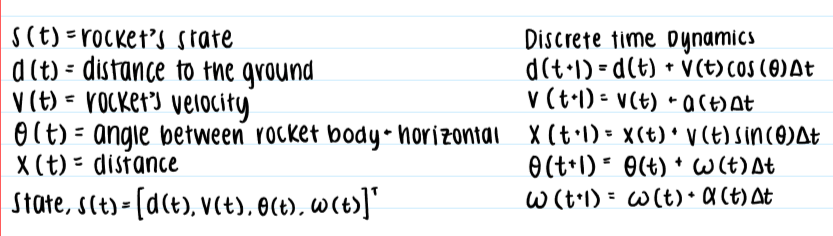

In [2]:
# Displaying Images for Project Formulation

# Control inputs
from IPython.display import Image
Image('control input.png')

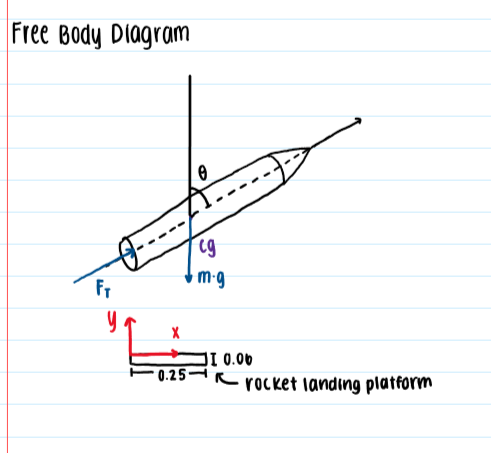

In [3]:
# FBD
from IPython.display import Image
Image('FBD.png')

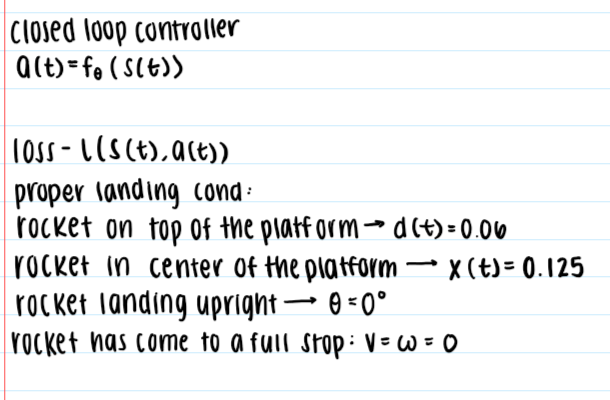

In [4]:
# loss function
from IPython.display import Image
Image('loss.png')

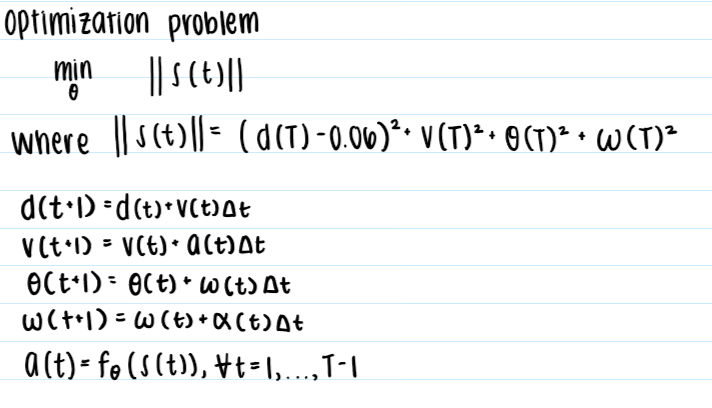

In [5]:
# optimization
from IPython.display import Image
Image('optimization.png')

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval in s
GRAVITY_ACCEL = 0.12  # gravity constant in m/s^2
BOOST_ACCEL = 0.18  # thrust constant in m/s^2
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height in m
ROTATION_ACCEL = 20  # rotation constant in degree/s^2

# Assumptions
# 0. Assuming the mass is a point body so moment of inertia, equations of motion, mass, and length of the rocket can be neglected
# 1. The nozzle cannot gimble therefore the thrust direction is parallel to body of the rocket
# 2. Neglecting any drag
# 3. Representing the system in 2D

In [21]:
# define system dynamics

# Defines the base class for the neural network, everything is sublass of this
class Dynamics(nn.Module):

    
    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = velocity
        state[2] = theta
        state[3] = theta_dot
        state[4] = x
        """
        # Apply gravity
        # this is the a(t+1) in  v(t+1) = v(t) + a(t+1) caused by gravity
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL*FRAME_TIME*math.cos(ROTATION_ACCEL*FRAME_TIME*2*math.pi/360), 0., 0.,0.])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # This is representative of the acceleration in the y direction
        # It is multiplied by the cos of the angle because the thrust is no longer fully vertical which will become negative if the rocket rotates 180 degrees
        delta_state =   BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1 , 0, 0, 0]) * action
        
        # Angular acceleration
        # Assumes Positive is in the clockwise direction
        delta_angle = t.tensor([0., 0., 0., ROTATION_ACCEL*FRAME_TIME*2*math.pi/360,0]) * action
          
        state = state + delta_state + delta_state_gravity + delta_angle 
        
        # Update state
        # Here is where you are replacing your previous values with your updated values
        step_mat = t.tensor([[1, (math.cos((ROTATION_ACCEL*FRAME_TIME*2*math.pi/360)))*FRAME_TIME, 0., 0.,0],
                            [0., 1., 0., 0.,0.],
                            [0., 0., 1., FRAME_TIME,0.],
                            [0., 0., 0., 1. ,0.],
                            [0., (math.sin((ROTATION_ACCEL*FRAME_TIME*2*math.pi/360)))*FRAME_TIME, 0., 0., 1.],
                            ])
        state = t.matmul(step_mat, state)

        return state

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        # Sequential creates a model so that nn.linear will be the input to nn.Tanh which will be the input to nn.Linear and so on
        self.network = nn.Sequential(
            # This does a linear transformation
            nn.Linear(dim_input, dim_hidden),
            # Takes value from above and outputs values from -1 and 1
            nn.Tanh(),
            # Does another linear transformation
            nn.Linear(dim_hidden, dim_output),
            # Takes values from above and outputs values from 0 to 1
            # You can add more layers here
            nn.Sigmoid(),
            
            
            
        )
            

    def forward(self, state):
        # this uses state to create action, uses state values in function above
        action = self.network(state)
        return action

In [17]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            # This is calling subclasses from controller and dynamics classes
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0.2, 0., 2*2*math.pi/360, 0., -1]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()
    # Defining the proper landing conditions as d = 0.06, v = 0, theta = 0, omega = 0
    def error(self, state):
        return (PLATFORM_HEIGHT-state[0])**2 + state[1]**2 + (state[2])**2 + (state[3])**2 + (state[4]-(PLATFORM_WIDTH/2))**2
        

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y = data[:, 0]
        vx = (math.cos((ROTATION_ACCEL*FRAME_TIME*2*math.pi/360)))*data[:, 1]
        vy = (math.sin((ROTATION_ACCEL*FRAME_TIME*2*math.pi/360)))*data[:, 1]
        theta = data[:, 2]
        #if theta[2] >= 0:
         #   theta[2] = 0
        theta_dot = data[:, 3]
        x = data[:,4]
        #x_dot = data[:,5]
    
        
       
      
        plt.plot(y, vy)
        plt.xlabel('d')
        plt.ylabel('v')
        plt.show()
        
        plt.plot(theta, theta_dot)
        plt.xlabel('theta')
        plt.ylabel('theta dot')     
        plt.show()
        
       # plt.subplot(1, 3, 3)
        plt.plot(x, vx)
        plt.xlabel('x')
        plt.ylabel('x dot')
        plt.show()

[1] loss: 99.171


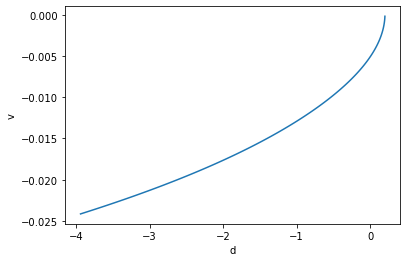

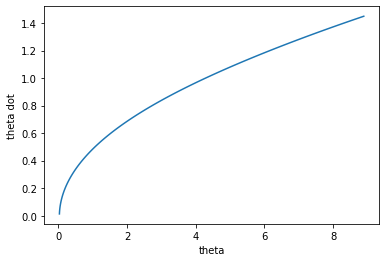

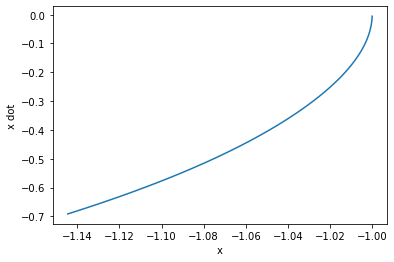

[2] loss: 81.738


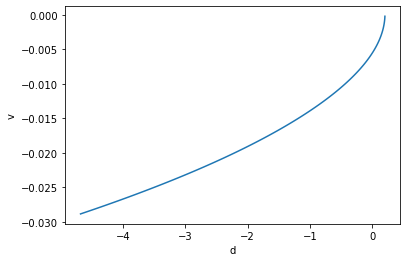

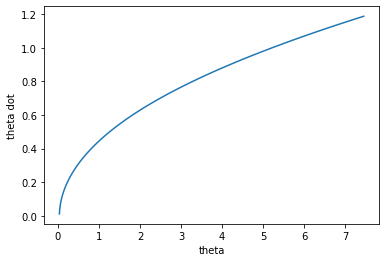

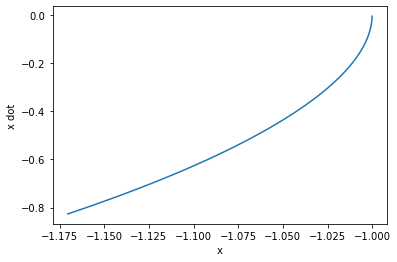

[3] loss: 71.958


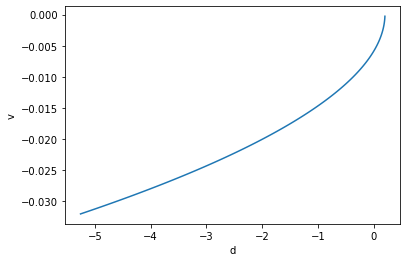

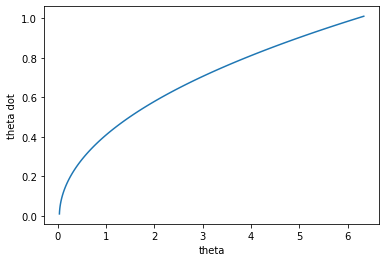

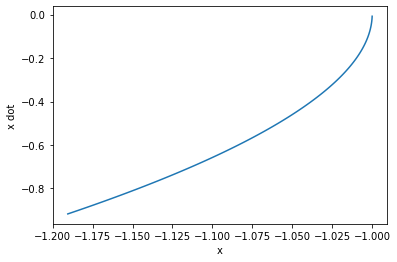

[4] loss: 66.982


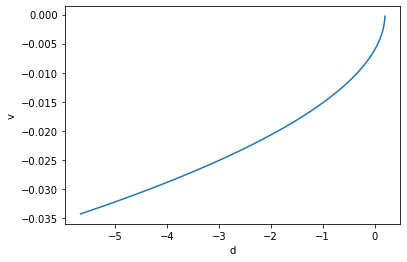

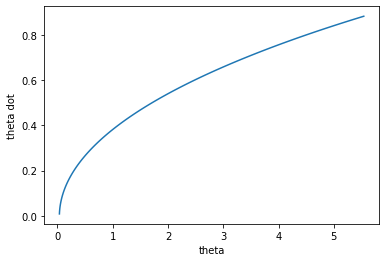

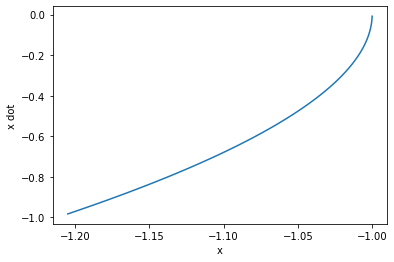

[5] loss: 64.622


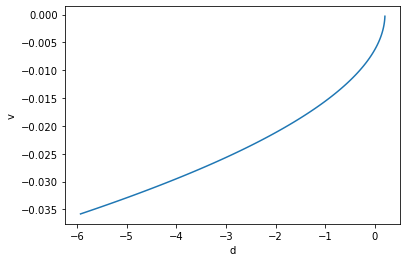

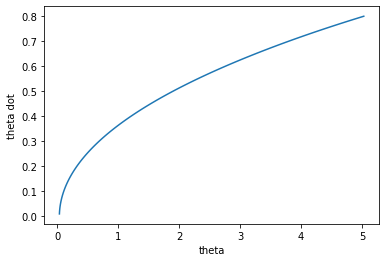

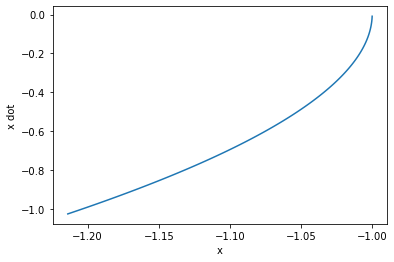

[6] loss: 63.327


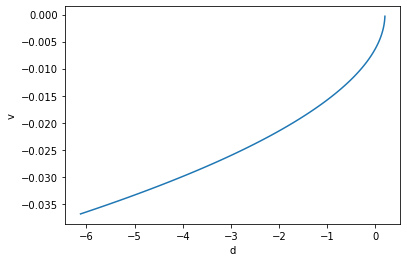

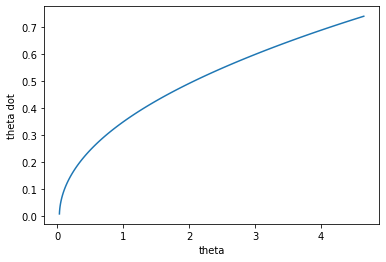

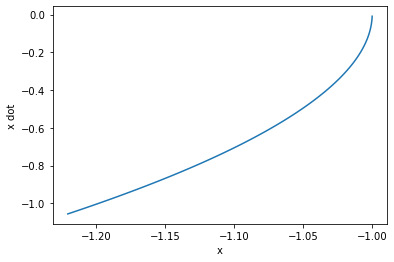

[7] loss: 62.580


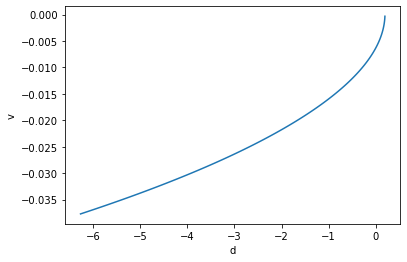

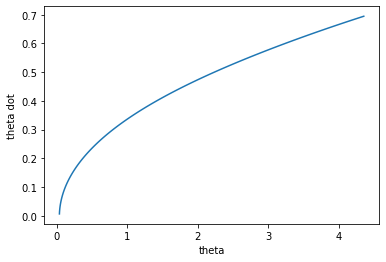

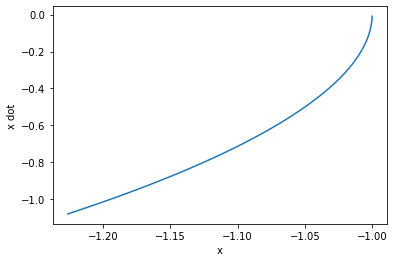

[8] loss: 62.184


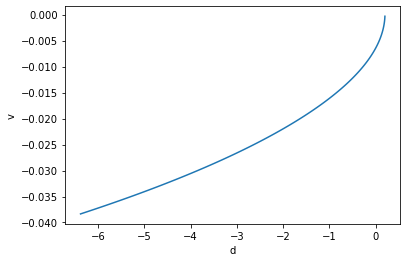

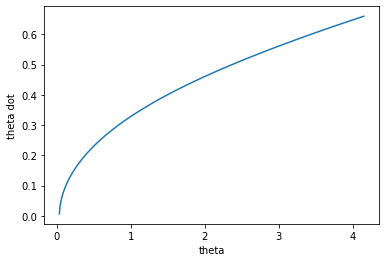

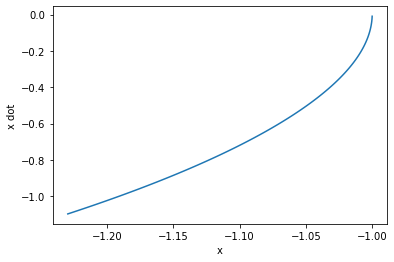

[9] loss: 61.972


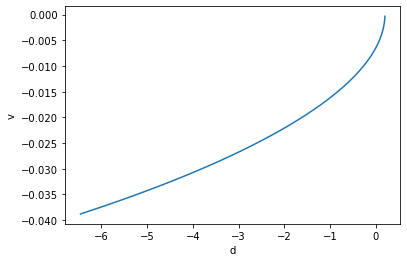

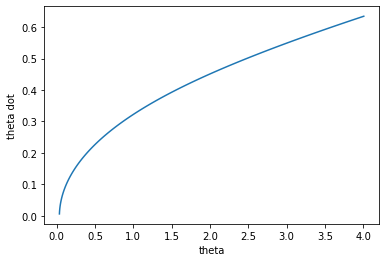

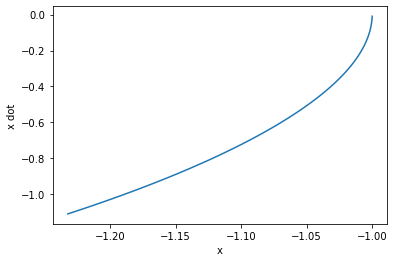

[10] loss: 61.851


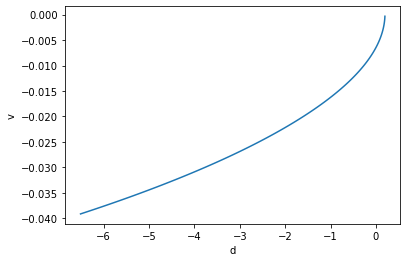

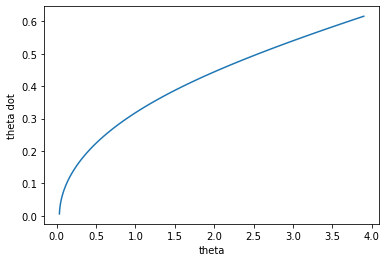

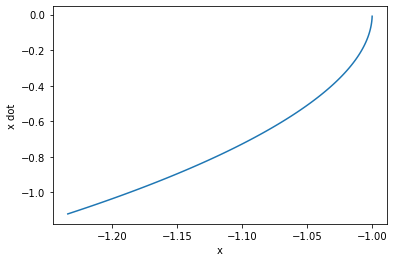

[11] loss: 61.779


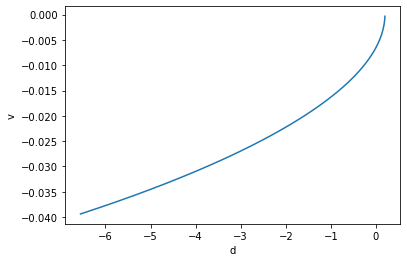

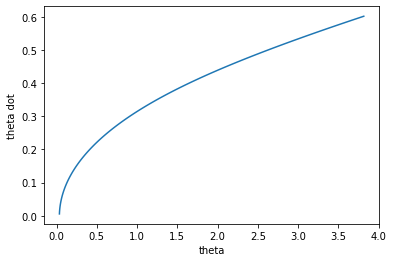

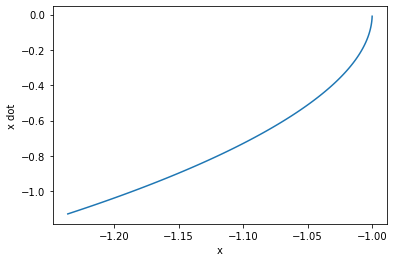

[12] loss: 61.735


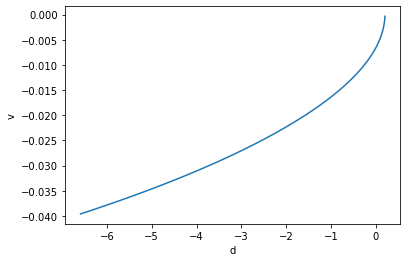

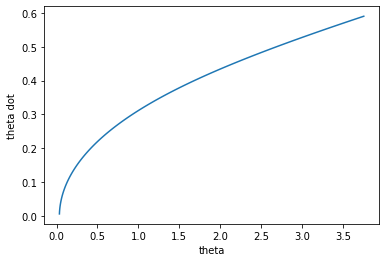

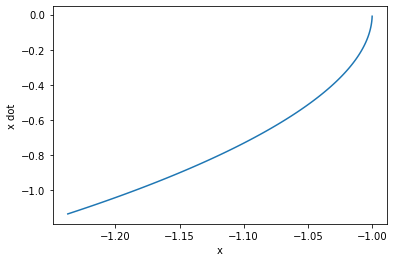

[13] loss: 61.706


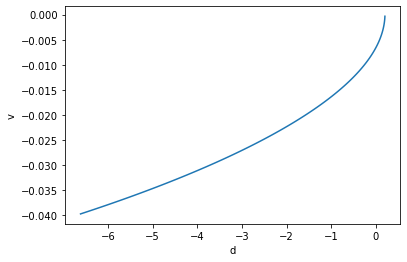

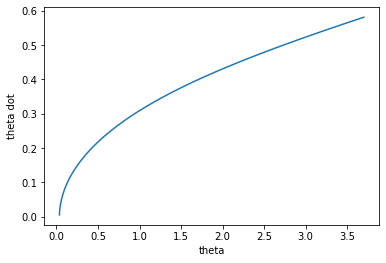

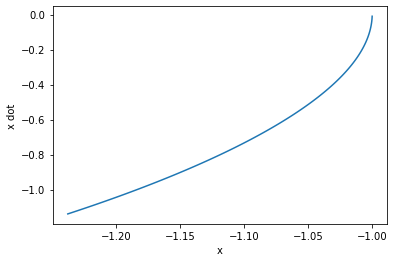

[14] loss: 61.689


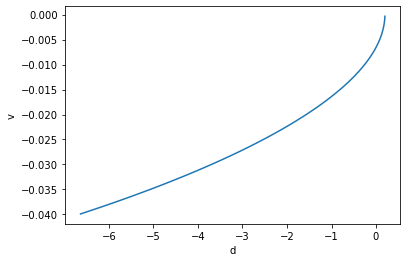

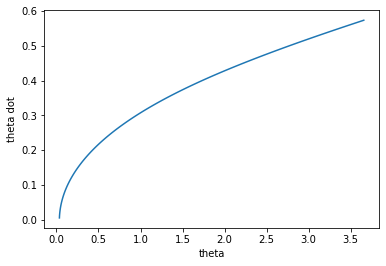

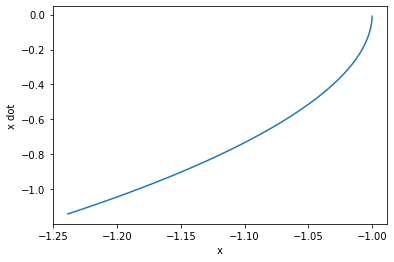

[15] loss: 61.679


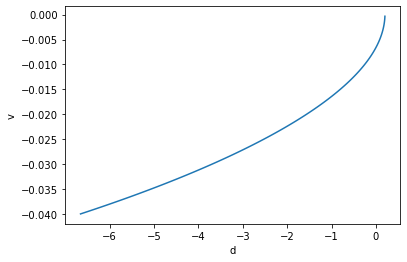

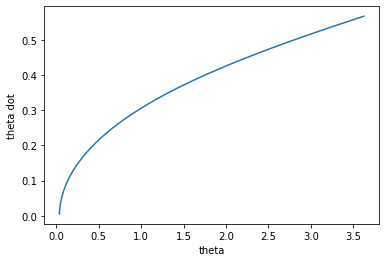

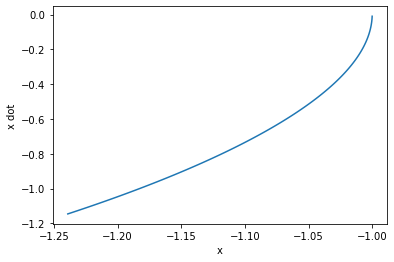

[16] loss: 61.673


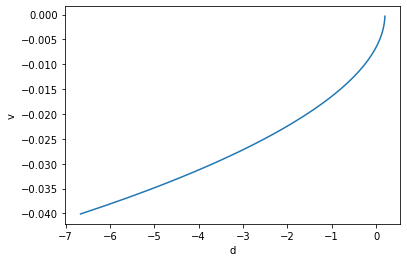

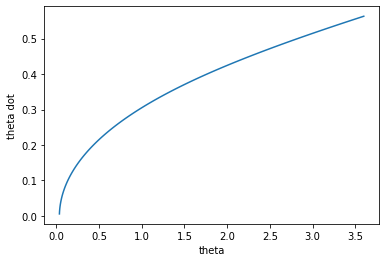

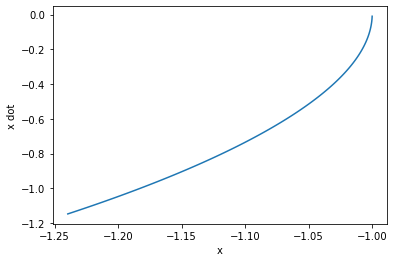

[17] loss: 61.669


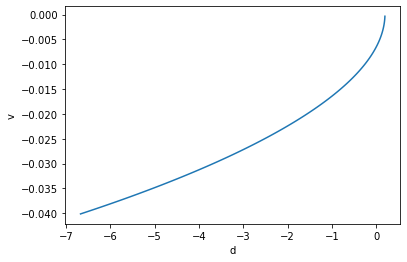

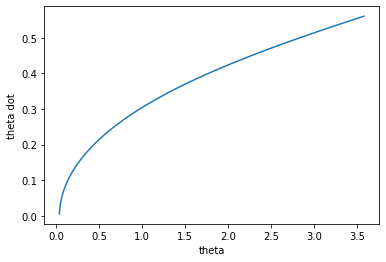

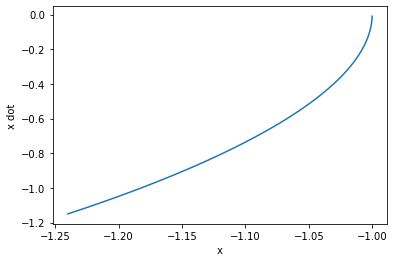

[18] loss: 61.667


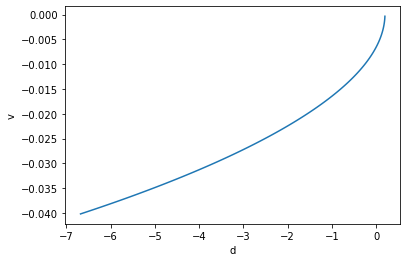

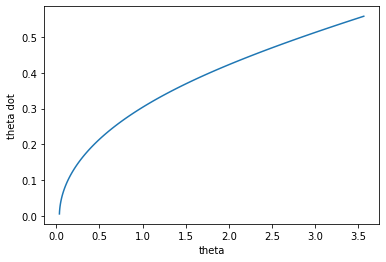

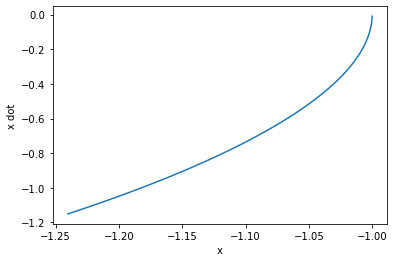

[19] loss: 61.666


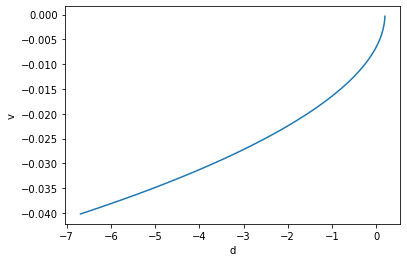

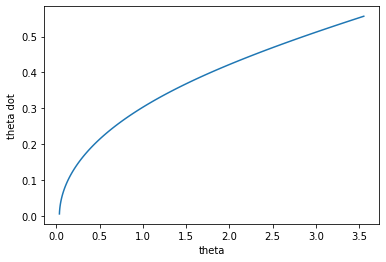

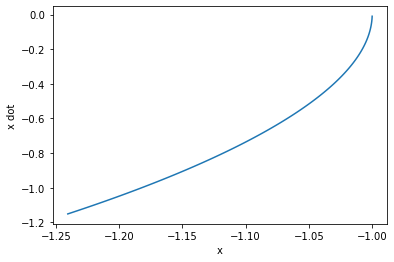

[20] loss: 61.665


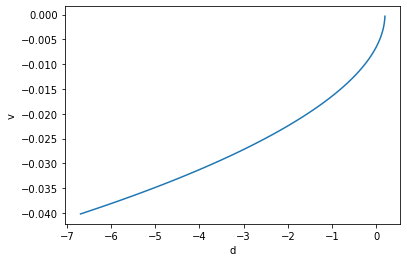

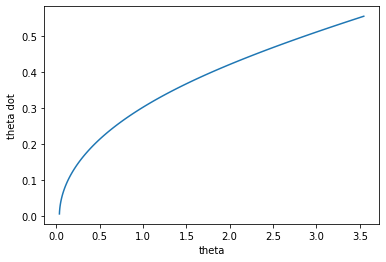

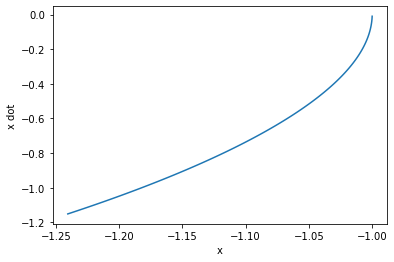

[21] loss: 61.665


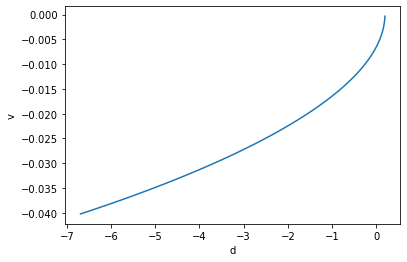

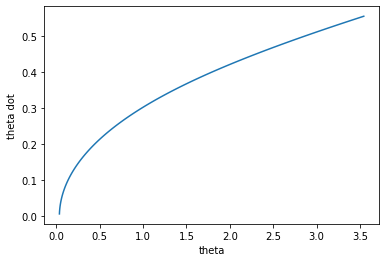

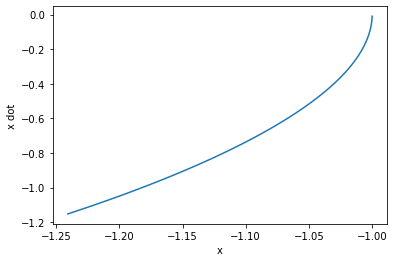

[22] loss: 61.665


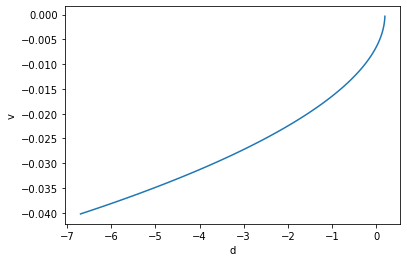

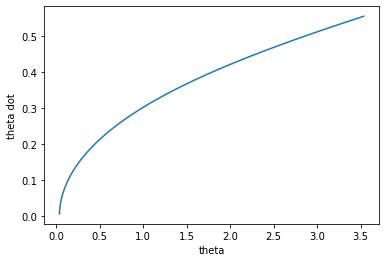

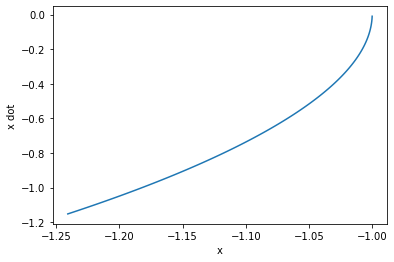

[23] loss: 61.665


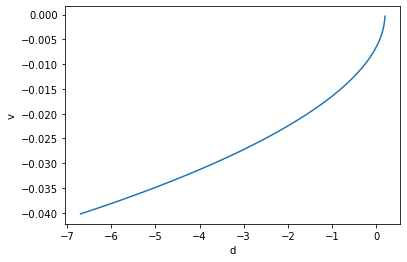

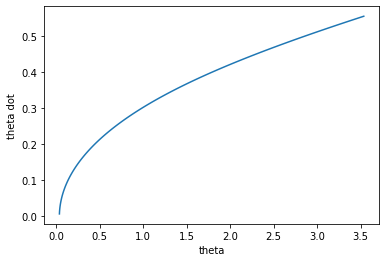

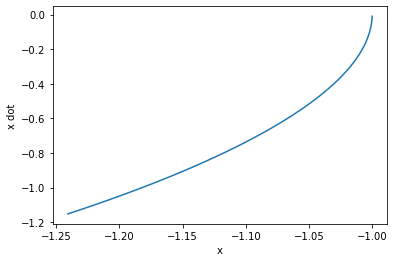

[24] loss: 61.664


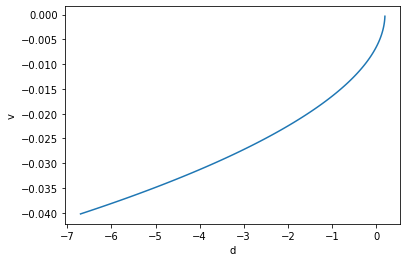

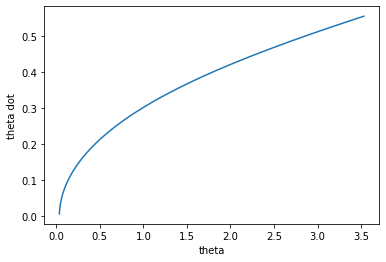

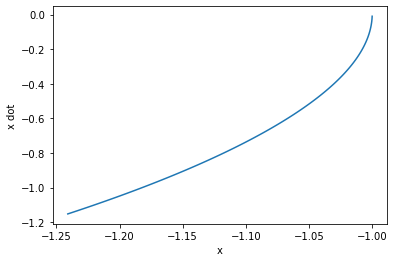

[25] loss: 61.664


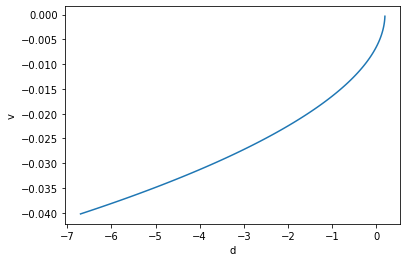

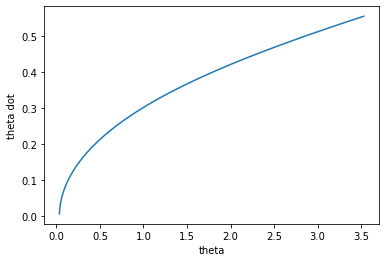

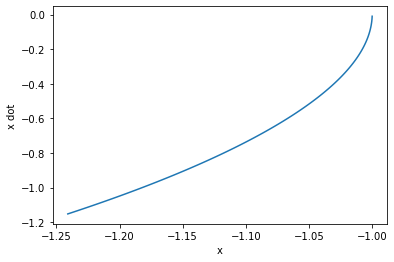

[26] loss: 61.664


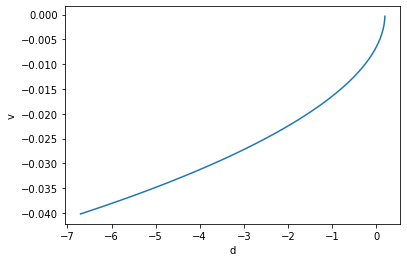

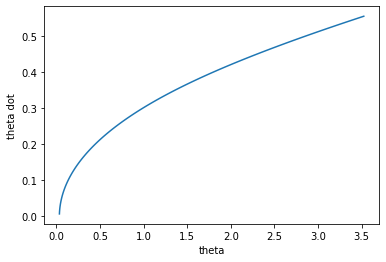

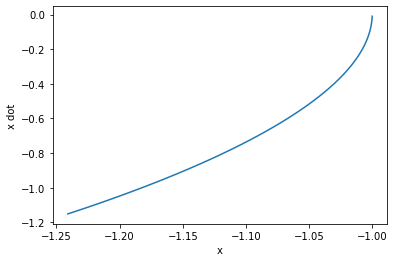

[27] loss: 61.664


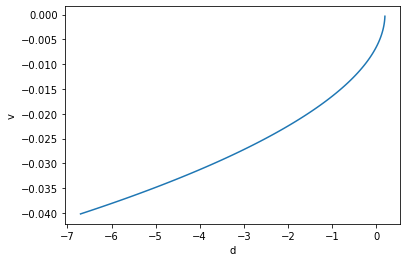

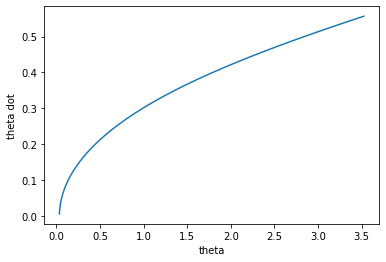

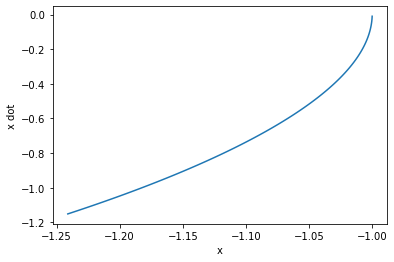

[28] loss: 61.664


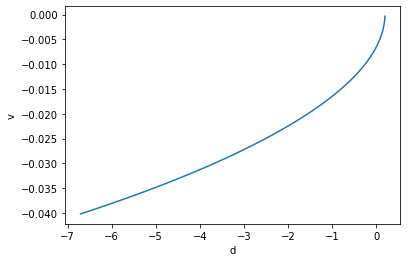

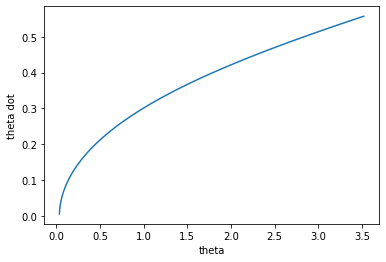

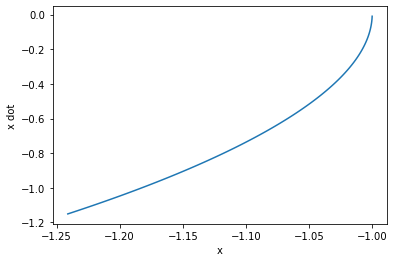

[29] loss: 61.664


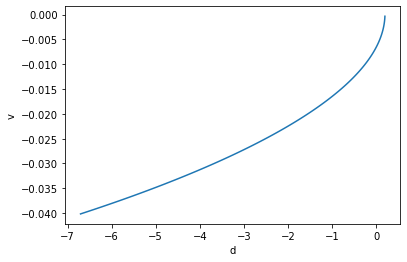

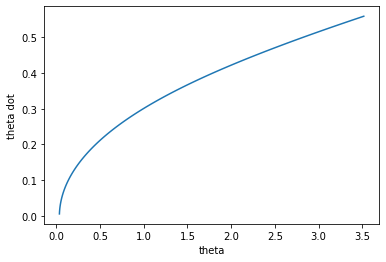

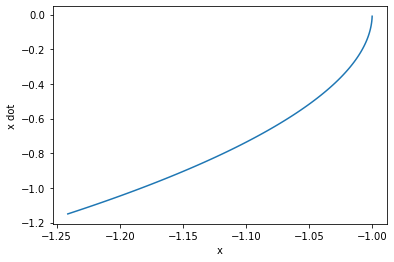

[30] loss: 61.664


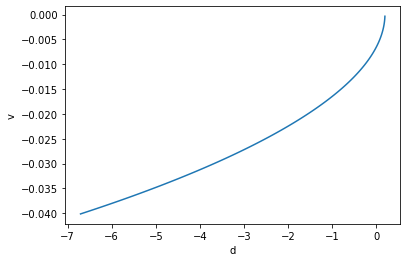

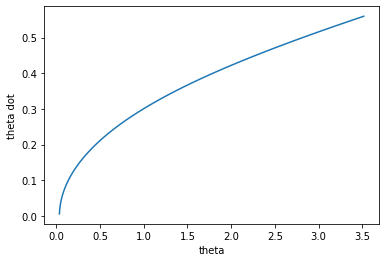

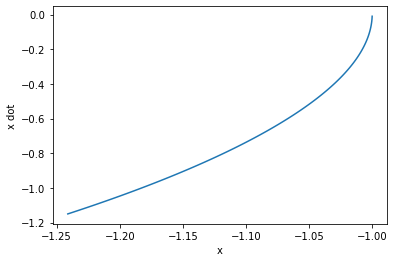

[31] loss: 61.663


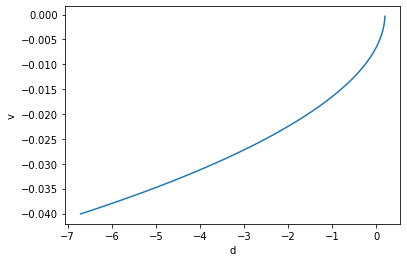

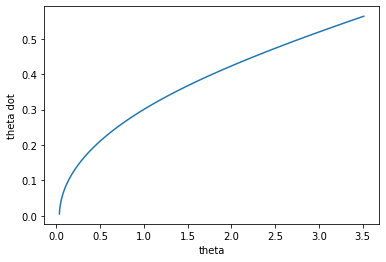

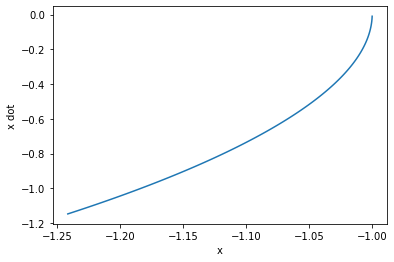

[32] loss: 61.663


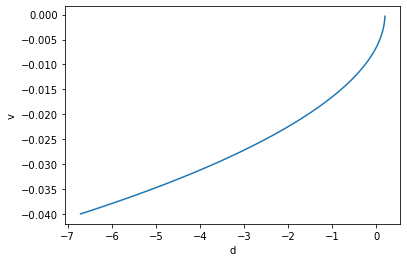

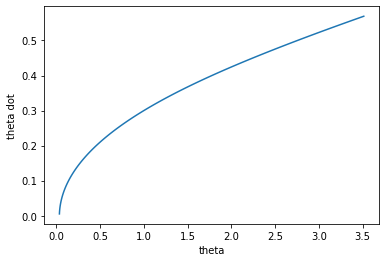

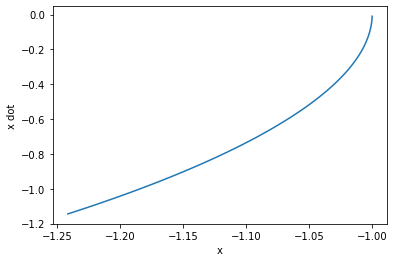

[33] loss: 61.663


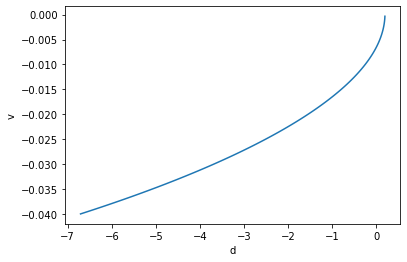

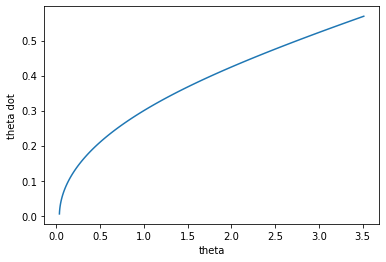

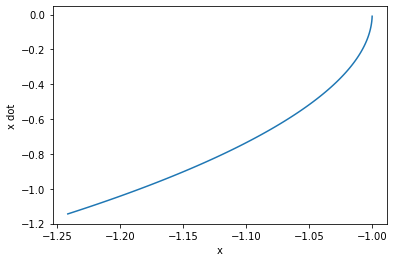

[34] loss: 61.663


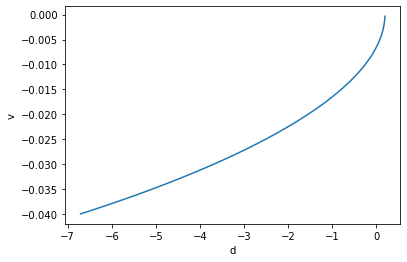

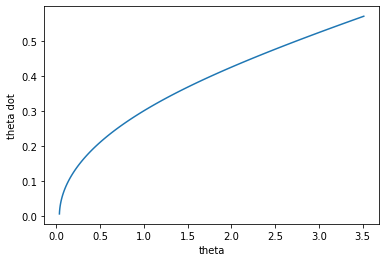

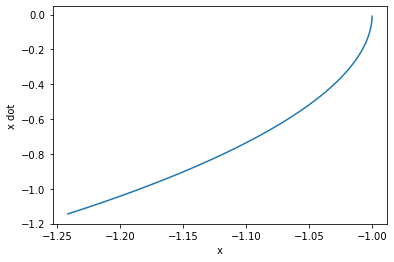

[35] loss: 61.663


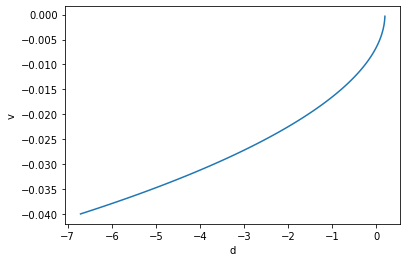

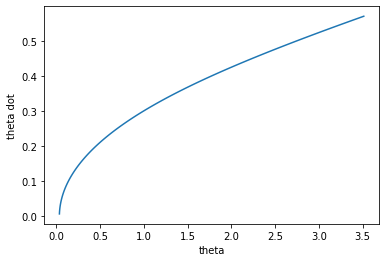

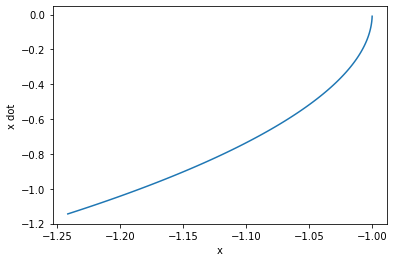

[36] loss: 61.663


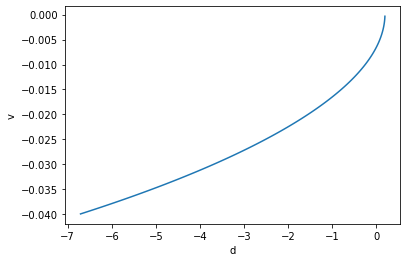

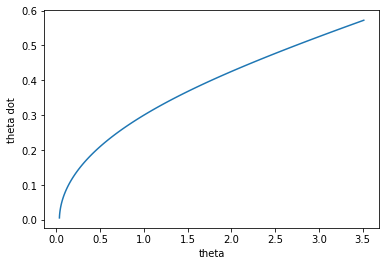

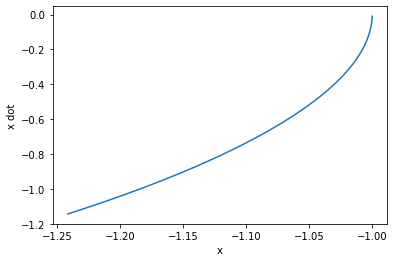

[37] loss: 61.663


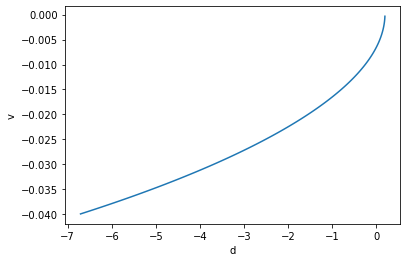

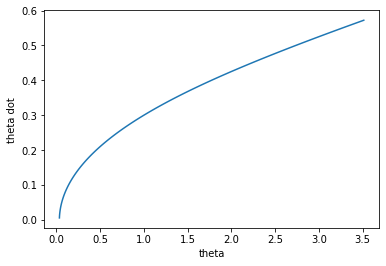

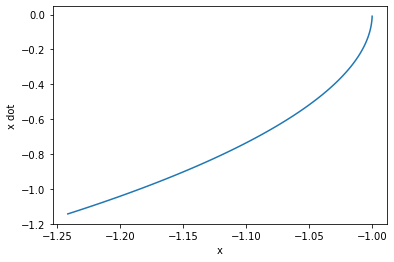

[38] loss: 61.663


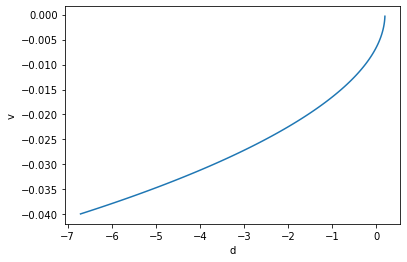

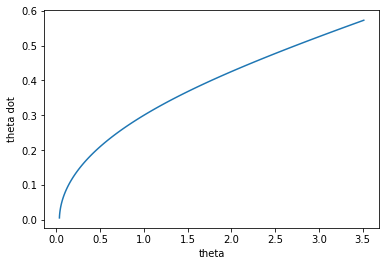

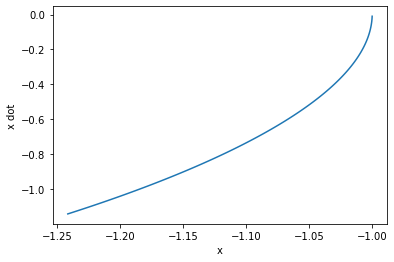

[39] loss: 61.663


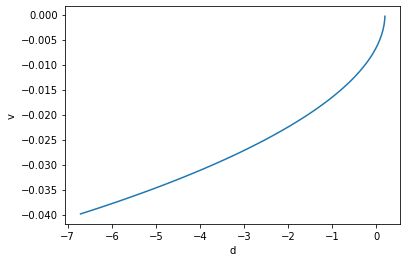

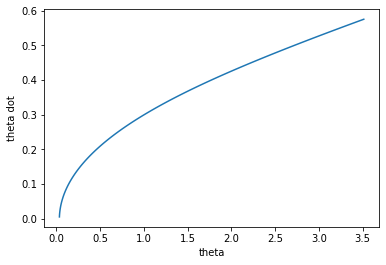

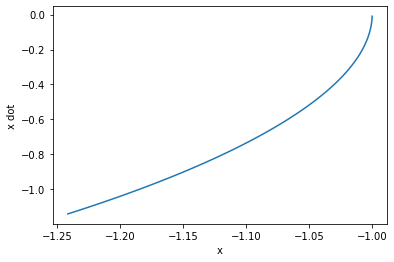

[40] loss: 61.663


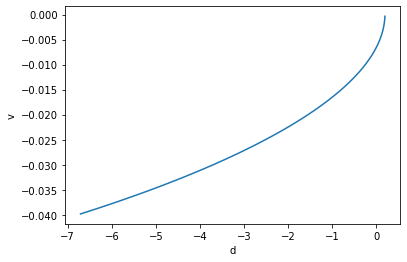

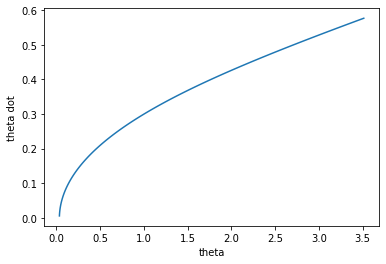

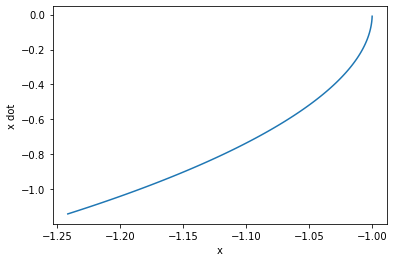

In [22]:
# Now it's time to run the code!

T = 120 # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem - 40 represents the number of iterations you want to train it for

In [58]:
# Analysis of Results
# 0. There is still a significant amount of loss meaning that the model created is not fully accurate. The majority of this loss is coming from the...
# rocket's position from the ground and the rockets distance from the platform. This error could be due to the way the loss was formatted in the section...
# and if I were to improve this model I would focus on those two variables and what makes their error so high.
# 1. Looking at the rocket's final graphs, starting with the v and d graph, the curve for this graph seems to be rotated 90 degrees from where it should be...
# the graphs gives different values of velocity for the same height but it is reaching a velocity of 0 whenit is close to approaching the platform. To...
# check on this, I would try different starting positions in the y to see if the rocket is just starting out so low that it needs to excessively over ...
# compensate because the the rockets angle from the horizontal has not reached zero yet
# 2. For the change in theta, angular velocity is reaching zero when rocket is upright which is good however, the angular velocity plateaus at a theta of 5,...
# I am curious if this has to do with why the graph above is incorrect and would like to see how this graph would change if the starting positons varied as well...
# as how this would vary if I were to have it start facing straight down rather than straight up
# 3. For the third graph, the velocity in the x reaches 0 at 3 which is where the center of the platform is, aka the optimal landing spot. As the rocket goes...
# further away in the positive direction the velocity in the x is negative in order to return it to the optimal point, but just past 3.7 there is a siginificant...
# jump in the positive direction for the graph. This is my opinion is probably related to the other problems that the previous graphs are experiencing because if...
# the rocket is doing a 180 degree flip, then all of a sudden the direction of the velocity switches from postive to negative, causing the rocket to have to...
# figure out how to reset its process and change directions quickly.

# set y pos to 6 and the lowest loss is 37.528
# set y pos to 5 and the lowest loss is 31.382
# set y pos to 4 and the lowest loss is 27.44
# set y pos to 3 and the lowest loss is 23.988
# set y pos to 2 and the lowest loss is 21.182
# set y pos to 20 and the lowest loss is 316.898
# set y pos to 30 and the lowest loss is 755.132
# set y to 1 and angle to 135 lowest loss is 19.388
# set y to 1 and angle to 180 lowest loss is 19.952
# set y to 1 and angle to 157.5 lowest loss is 19.666
# set y to 3 and angle to 135 lowest loss is 24.640
# set y to 10 and angle to 135 lowest loss is 78.736
# set y to 10 and angle to 157.5 lowest loss is 79.135
# set y to 10 and angle to 180 lowest loss is 79.546
# set y to 10 and angle to 110 lowest loss is 78.301
# set y to 5 and angle to 110 lowest loss is 32.422
# set y to 2 and angle to 110 lowest loss is 21.433
# set y to 1 and angle to 110 lowest loss is 19.087
# set y to 1 and angle to 200 lowest loss is 20.212
# set y to 1 and angle to 290 lowest loss is 21.451
# Set y to 1 angle to 110 and x to -2 and loss is 6.261
# Set y to 1 angle to 110 and x to -1 and loss is 5.679
# Set y to 1 angle to 90 and x to -1 and loss is 5.431
# Set y to 2 angle to 90 and x to -1 and loss is 6.880
# Set y to 3 angle to 90 and x to -1 and loss is 8.515
# Set y to 1 angle to 45 and x to -1 and loss is 4.895
# Set y to 1 angle to 22.5 and x to -1 and loss is 4.638
# Set y to 1 angle to 0 and x to -1 and loss is 4.388
# Set y to 1 angle to 340 and x to -1 and loss is 8.928
# Set y to 1 angle to 360 and x to -1 and loss is 9.246
# Set y to 1 angle to 0 and x to 0 and loss is 4.938
# Set y to 1 angle to 0 and x to -0.5 and loss is 4.938
# Set y to 1 angle to 0 and x to -0.5 and loss is 4.497
# Set y to 0.8 angle to 0 and x to 0 and loss is 4.684
# Set y to 0.8 angle to 0 and x to -1 and loss is 4.148 
# Set y to 0.7 angle to 0 and x to -1 and loss is 4.030
# Set y to 0.6 angle to 0 and x to -1 and loss is 3.914
# Set y to 0.5 angle to 0 and x to -1 and loss is 3.688
# Set y to 0.3 angle to 0 and x to -1 and loss is 3.577
# Set y to 0.2 angle to 2 and x to -1 and loss is 3.488

In [24]:
math.cos(math.pi)


-1.0

## 3. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 